The purpose of this analysis is to understand the computational performance of our molecular dynamics simulations using NEP (Neural Equivariant Potential) machine learning potentials on an HPC cluster. Specifically, we aim to estimate how many timesteps we can simulate in 24 hours for a given system size (number of atoms) and a specified number of CPU cores.

####  What We Have
We ran a series of test simulations with different configurations (varied number of atoms and CPUs) and measured:

- no_of_cpus: Number of CPU cores used for the simulation.

- no_of_atoms: Total number of atoms in the simulation.

- spcpu: Simulation speed, i.e., timesteps per second per CPU, which we extracted from the LAMMPS log or output.



In [14]:
import numpy as np
import matplotlib.pyplot as plt

no_of_cpus = np.array([4, 64,  40, 40, 40, 64, 64, 40, 4, 16, 32, 32, 38, 38, 38, 64, 64, 64, 128, 128])
no_of_atoms = np.array([4000, 13500, 23328, 32000, 42592, 50784, 62500, 70304, 108000, 108000, 500000, 1098500, 10976, 19652, 108000, 108000, 500000, 1098500, 500000, 1098500])
spcpu = np.array([4.32, 27.93, 10.196, 7.74, 5.958, 7.937, 6.7173, 3.64, 0.263, 0.9656, 0.71258,0.1883, 26.27, 22.406, 3.4742, 6.013, 1.38, 0.5324611, 2.85, 1.3132])

In [ ]:
From this, we calculated:

efficiency = spcpu / no_of_cpus: A normalized measure of computational efficiency, which allows us to compare performance across different CPU counts.

In [15]:
efficiency = spcpu / no_of_cpus
print(f'efficiency:{efficiency}')

efficiency:[1.08       0.43640625 0.2549     0.1935     0.14895    0.12401563
 0.10495781 0.091      0.06575    0.06035    0.02226812 0.00588437
 0.69131579 0.58963158 0.09142632 0.09395312 0.0215625  0.0083197
 0.02226563 0.01025937]


### What We Did
Plotted the normalized performance (spcpu / no_of_cpus) vs. the number of atoms.

Fitted a power-law curve to the data of the form:

**efficiency** = 𝑎⋅(no_of_atoms)^𝑏
 
using nonlinear regression (scipy.optimize.curve_fit()).

Obtained the fitted parameters:

a: scaling factor

b: exponent describing how efficiency scales with system size

This model allows us to predict the efficiency for any new number of atoms.

Fitted parameter a: 4.886624e+02
Fitted parameter b: -0.7307


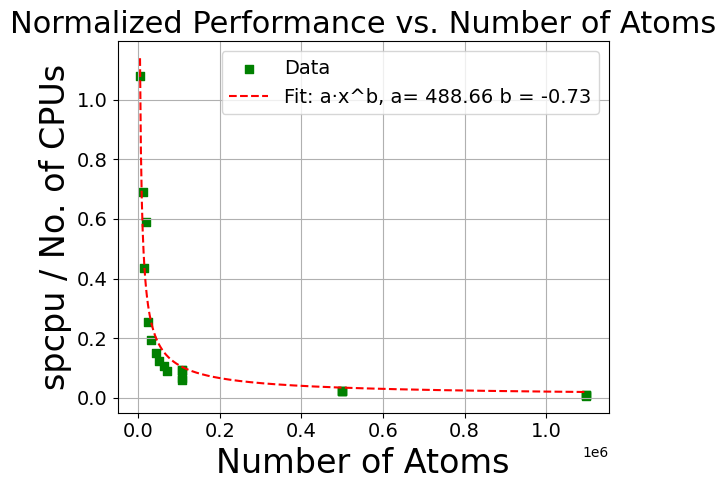

In [29]:
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * x**b

# Fit the model
popt, _ = curve_fit(power_law, no_of_atoms, efficiency, p0=(1e-10, 1))

print(f"Fitted parameter a: {popt[0]:.6e}")  # scientific notation
print(f"Fitted parameter b: {popt[1]:.4f}")  # 4 decimals
# Generate fit line
x_fit = np.linspace(min(no_of_atoms), max(no_of_atoms), 500)
y_fit = power_law(x_fit, *popt)

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(no_of_atoms, efficiency, c='green', marker='s', label='Data')
plt.plot(x_fit, y_fit, 'r--', label=f'Fit: a·x^b, a= {popt[0]:.2f} b = {popt[1]:.2f}')
plt.xlabel('Number of Atoms', fontsize=24)
plt.ylabel('spcpu / No. of CPUs', fontsize=24)
plt.title('Normalized Performance vs. Number of Atoms', fontsize=22)
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


Estimating Steps in 24 Hours
Once we have the fitted model, we can estimate the total number of timesteps achievable in 24 hours for any simulation setup using the following steps:

Use the fitted power-law model to calculate:


efficiency = a⋅(no_of_atoms)^b
 
Multiply by the desired number of CPUs:

spcpu = efficiency × no_of_cpus 

Multiply by the number of seconds in 24 hours:

timesteps_in_24h = spcpu × 86400
timesteps_in_24h=spcpu×86400
This gives an estimate of how many timesteps can be completed in one full day of compute time.

In [32]:
atoms_to_predict =   2594454
predicted_efficiency = power_law(atoms_to_predict, *popt)
print(f"Predicted efficiency (steps/(CPU·sec)) at {atoms_to_predict} atoms: {predicted_efficiency:.6f}")


Predicted efficiency (steps/(CPU·sec)) at 2594454 atoms: 0.010050


In [33]:
cpus = 128
time_seconds = 24 * 3600  

total_steps = predicted_efficiency * cpus * time_seconds
print(f"Estimated steps in 24 hours with {cpus} CPUs: {int(total_steps)}")


Estimated steps in 24 hours with 128 CPUs: 111140
